In [1]:
# algo_trading.py  python library dependencies

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import alpaca_trade_api as tradeapi
import time
import matplotlib.pyplot as plt

In [3]:
# Step 1: Data Collection

In [4]:
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [5]:
# Step 2: Data Preprocessing

In [6]:
def preprocess_data(data):
    data = data.dropna()
    return data

In [7]:
# Step 3: Feature Engineering

In [8]:
def create_features(data):
    # Moving Averages
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    
    # RSI
    data['RSI'] = compute_rsi(data['Close'])
    
    # Price Change
    data['Price_Change'] = data['Close'].pct_change()
    
    # Candlestick Patterns (Price Action)
    data['Bullish_Engulfing'] = bullish_engulfing(data)
    data['Bearish_Engulfing'] = bearish_engulfing(data)
    
    # Day Low Strategy
    data['Near_Day_Low'] = (data['Close'] - data['Low']) / (data['High'] - data['Low'])
    
    # Future Close Price for Labels
    data['Future_Close'] = data['Close'].shift(-1)
    
    data = data.dropna()
    return data

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

def bullish_engulfing(data):
    pattern = ((data['Close'] > data['Open']) & 
               (data['Close'].shift(1) < data['Open'].shift(1)) & 
               (data['Close'] > data['Open'].shift(1)) & 
               (data['Open'] < data['Close'].shift(1)))
    return pattern.astype(int)

def bearish_engulfing(data):
    pattern = ((data['Close'] < data['Open']) & 
               (data['Close'].shift(1) > data['Open'].shift(1)) & 
               (data['Close'] < data['Open'].shift(1)) & 
               (data['Open'] > data['Close'].shift(1)))
    return pattern.astype(int)

In [9]:
# Step 4: Model Building

In [10]:
def build_model(data):
    features = ['SMA_50', 'SMA_200', 'RSI', 'Price_Change', 
                'Bullish_Engulfing', 'Bearish_Engulfing', 'Near_Day_Low']
    X = data[features]
    y = np.where(data['Future_Close'] > data['Close'], 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Model Accuracy: {accuracy:.2f}')
    return model

In [11]:
# Step 5: Backtesting

In [12]:
def backtest_strategy(model, data):
    features = ['SMA_50', 'SMA_200', 'RSI', 'Price_Change', 
                'Bullish_Engulfing', 'Bearish_Engulfing', 'Near_Day_Low']
    data['Pred_Signal'] = model.predict(data[features])
    data['Strategy_Returns'] = data['Pred_Signal'] * data['Price_Change'].shift(-1)
    data['Cumulative_Strategy_Returns'] = (data['Strategy_Returns'] + 1).cumprod()
    return data

In [13]:
# Step 6: Integration with Broker

def place_order(api, symbol, qty, side):
    try:
        order = api.submit_order(
            symbol=symbol,
            qty=qty,
            side=side,
            type='market',
            time_in_force='gtc'
        )
        print(f"Order placed: {order}")
    except Exception as e:
        print(f"Error placing order: {e}")

def connect_broker(api_key, api_secret, base_url):
    api = tradeapi.REST(api_key, api_secret, base_url, api_version='v2')
    return api

In [14]:
# Step 7: Running the Model

[*********************100%%**********************]  1 of 1 completed


Model Accuracy: 0.43


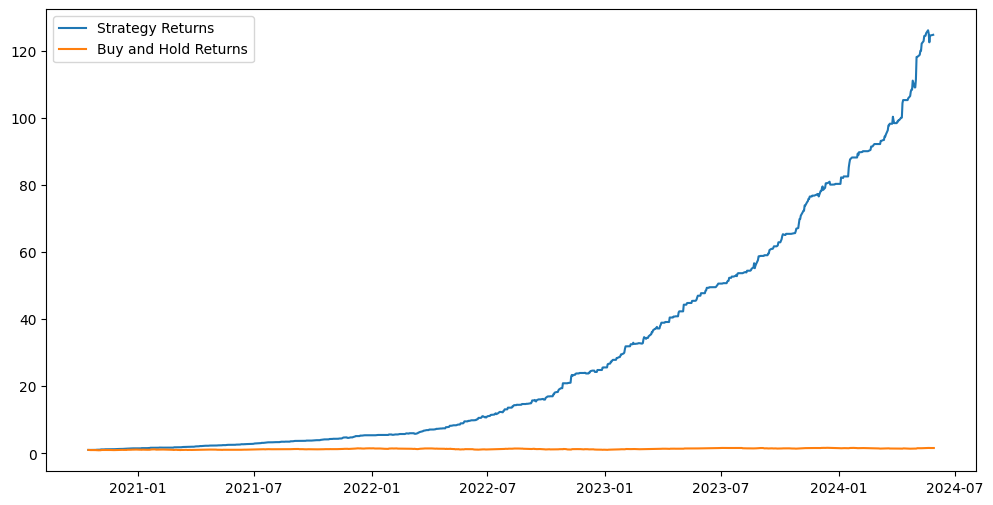

In [15]:
def main():
    ticker = 'AAPL'
    start_date = '2020-01-01'
    end_date = '2024-05-31'

    data = get_stock_data(ticker, start_date, end_date)
    data = preprocess_data(data)
    data = create_features(data)
    model = build_model(data)
    data = backtest_strategy(model, data)

    # Plot the cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(data['Cumulative_Strategy_Returns'], label='Strategy Returns')
    plt.plot((data['Close'] / data['Close'].iloc[0]), label='Buy and Hold Returns')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()